92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step


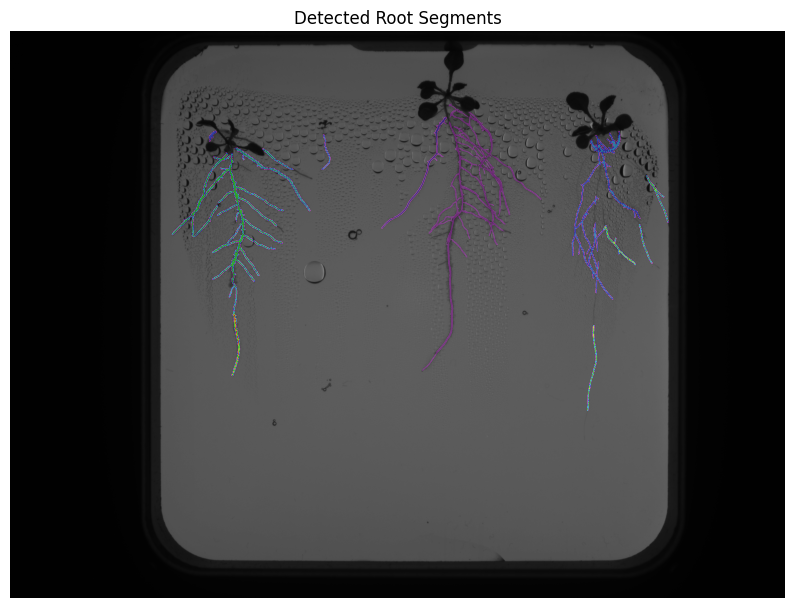

/var/folders/kz/slhyr0gd4qj4nrryyswvqv4c0000gn/T/ipykernel_27996/2399138420.py:83: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


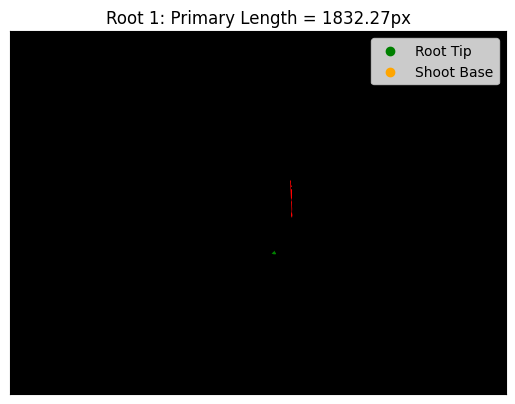

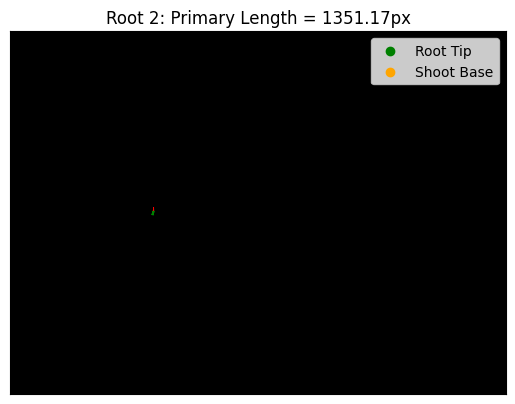

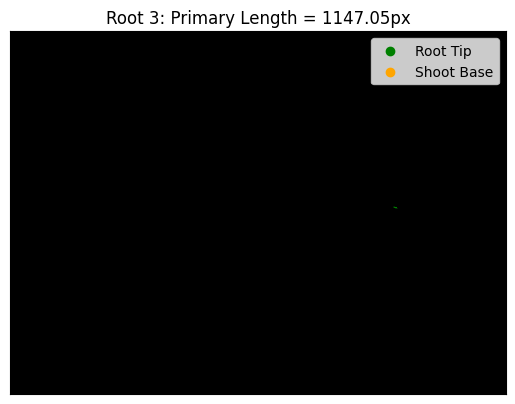

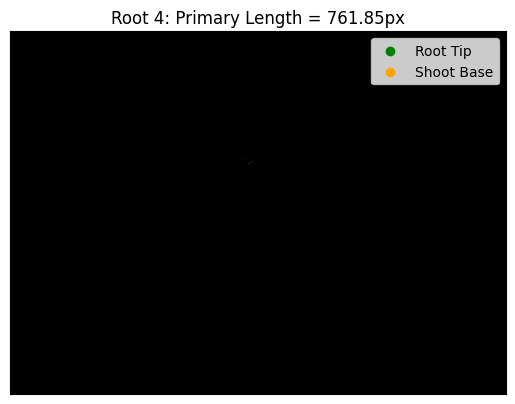

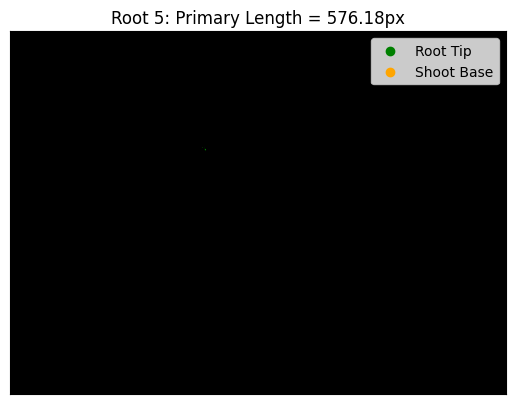

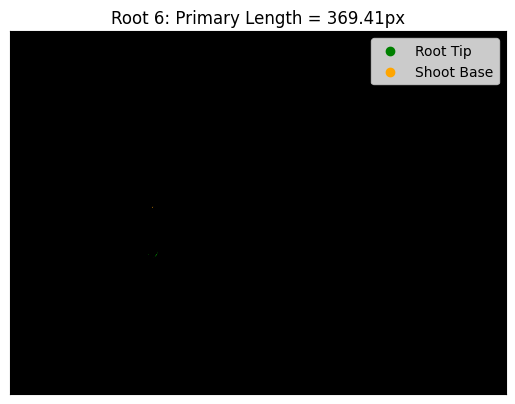

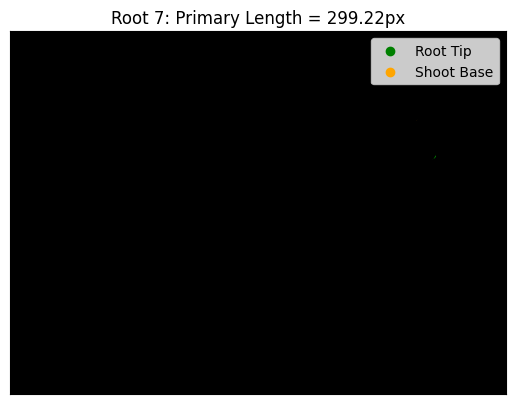

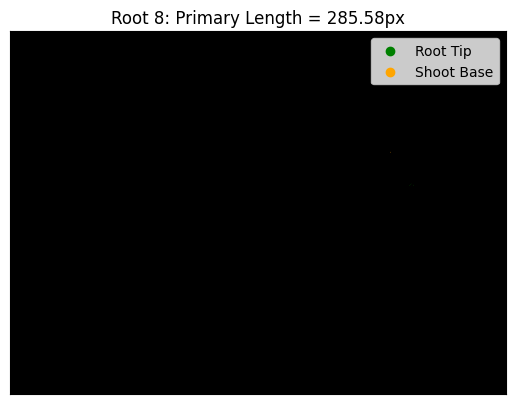

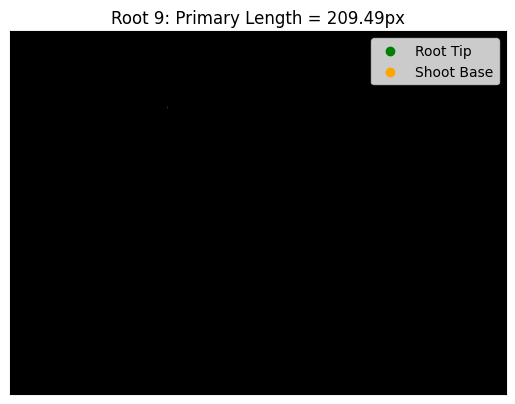

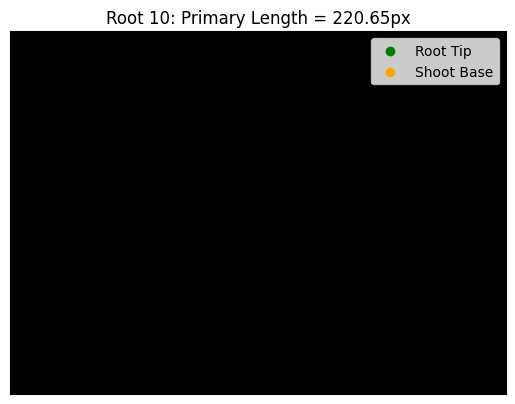

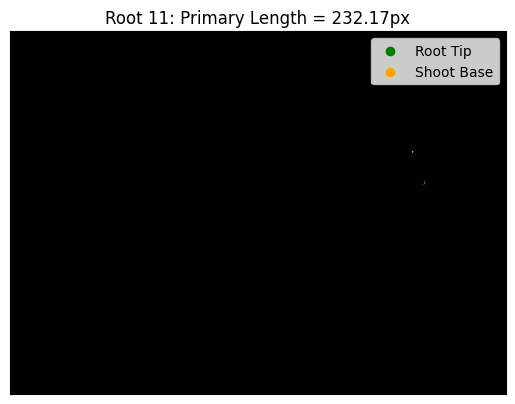

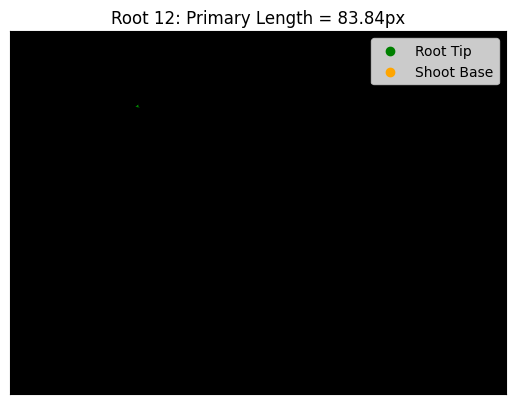

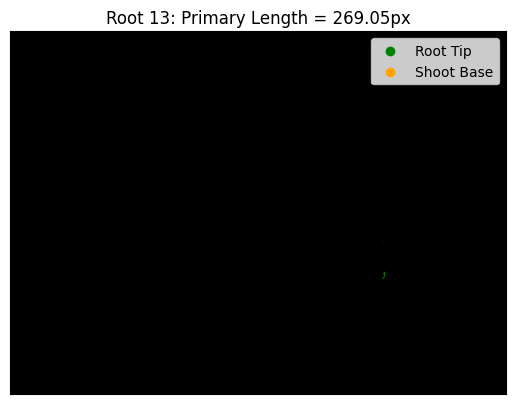

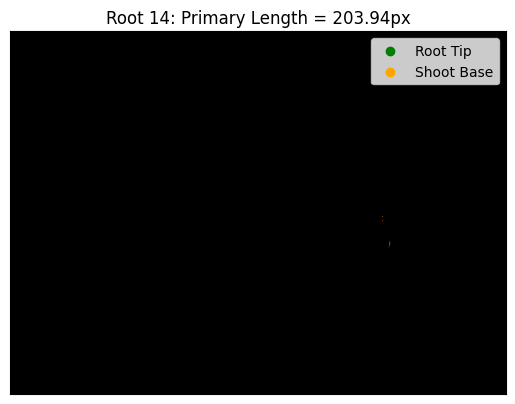


Root lengths saved to: root_lengths.csv


In [4]:
# Task 6 & 7: Individual Root Segmentation & RSA Extraction (Single Image)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify
from skimage.morphology import remove_small_objects, skeletonize
from skimage.measure import label, regionprops
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx
import csv
import os
import skimage.morphology as morph

# --- Paths ---
image_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image.png"
mask_pred_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image_prediction_celine_231265.png"
model_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/celine_231265_unet_model_256px.h5"

# --- Helper Functions ---
def padder(image, patch_size):
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = height_padding // 2
    bottom_padding = height_padding - top_padding
    left_padding = width_padding // 2
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

def unpad(image, padding):
    top, bottom, left, right = padding
    return image[top:image.shape[0]-bottom, left:image.shape[1]-right]

# --- Load Model and Image ---
model = load_model(model_path, compile=False)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
patch_size = 256
step_size = 64

# --- Preprocessing ---
padded_image, pad = padder(image, patch_size)
patches = patchify(padded_image, (patch_size, patch_size), step=step_size)
i, j = patches.shape[:2]
patches = patches.reshape(-1, patch_size, patch_size)

resized_patches = np.array([
    cv2.cvtColor(cv2.resize(p, (patch_size, patch_size)), cv2.COLOR_GRAY2RGB)
    for p in patches
])

preds = model.predict(resized_patches / 255.0)
root_preds = np.array([cv2.resize(p[..., 0], (patch_size, patch_size)) for p in preds])
root_preds = root_preds.reshape(i, j, patch_size, patch_size)
pred_mask = unpatchify(root_preds, padded_image.shape)
pred_mask = unpad(pred_mask, pad)

# --- Post-process mask ---
binary_mask = pred_mask > 0.08
cleaned_mask = remove_small_objects(binary_mask, min_size=750)


# Connect nearby fragments
cleaned_mask = morph.binary_closing(cleaned_mask, morph.disk(2))
labeled_mask = label(cleaned_mask)

# --- Visualization ---
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.imshow(labeled_mask, cmap='nipy_spectral', alpha=0.5)
plt.title("Detected Root Segments")
plt.axis('off')
plt.show()

# --- RSA Extraction ---
def analyze_root(mask, root_id):
    skel = skeletonize(mask)
    g0, c0 = skeleton_to_csgraph(skel)
    skeleton_obj = Skeleton(skel)
    branch_data = summarize(skeleton_obj)
    G = nx.from_pandas_edgelist(branch_data, 'node-id-src', 'node-id-dst', edge_attr='branch-distance')
    coords = np.transpose(c0)

    degree_1_nodes = [n for n in G.nodes if G.degree[n] == 1]
    if len(degree_1_nodes) < 2:
        print(f"Root {root_id}: Not enough endpoints found.")
        return None

    lowest = max(degree_1_nodes, key=lambda n: coords[n][0])
    highest = min(degree_1_nodes, key=lambda n: coords[n][0])

    try:
        path = nx.shortest_path(G, lowest, highest, weight='branch-distance')
        dist = nx.shortest_path_length(G, lowest, highest, weight='branch-distance')
    except nx.NetworkXNoPath:
        print(f"Root {root_id}: No path found.")
        return None

    # --- Visualization ---
    fig, ax = plt.subplots()
    draw.overlay_skeleton_networkx(g0, coords, image=skel, axis=ax, node_size=0)
    ax.scatter(*coords[lowest][::-1], c='green', label='Root Tip')
    ax.scatter(*coords[highest][::-1], c='orange', label='Shoot Base')
    for i in range(len(path)-1):
        y1, x1 = coords[path[i]]
        y2, x2 = coords[path[i+1]]
        ax.plot([x1, x2], [y1, y2], color='red', lw=1.5)
    ax.set_title(f"Root {root_id}: Primary Length = {dist:.2f}px")
    ax.legend()
    plt.show()
    return dist

# --- Analyze roots ---
regions = regionprops(labeled_mask)
regions = sorted(regions, key=lambda r: r.area, reverse=True)
plant_data = []
for idx, region in enumerate(regions):
    mask = labeled_mask == region.label
    length = analyze_root(mask, idx + 1)
    if length:
        plant_data.append((f"root_{idx+1}", length))

# --- Save to CSV ---
csv_file = "root_lengths.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Plant ID", "Length (px)"])
    for pid, length in plant_data:
        writer.writerow([pid, length])

# --- Done ---
print("\nRoot lengths saved to:", csv_file)


